<a href="https://colab.research.google.com/github/screemix/The_Glorious_Chargers/blob/main/The_Glorious_Chargers_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [411]:
import sys
import glob
import os
import io
import pickle
import statistics
import math
import pandas as pd
import numpy as np

import seaborn as sns

from datetime import datetime
from datetime import time
from datetime import date, timedelta

from dateutil.relativedelta import *

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pandas.tseries.offsets import *

%matplotlib inline

# pandas settings
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

In [412]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, \
                                    ShuffleSplit, cross_val_predict, TimeSeriesSplit, ParameterSampler, PredefinedSplit
from sklearn import metrics                                  
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import r2_score,  mean_squared_error, accuracy_score, mean_absolute_error, median_absolute_error, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV, SelectFromModel

import xgboost as xgb
from xgboost import plot_importance

In [413]:
# pip install fsspec

In [414]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data upload

In [415]:
train_v2 = pd.read_csv('./drive/My Drive/Colab Notebooks/NGWL The Glorious Chargers/01_preprocessed_data/train_v21.csv')
submission_features = pd.read_csv('./drive/My Drive/Colab Notebooks/NGWL The Glorious Chargers/01_preprocessed_data/submission_features.csv')
#submission_features = submission_features.drop(['gender',	'age'], axis = 1)
submission_features.head()


,Id,months_with_order,months_without_order,last_order_month,first_order_month,gender,age,n_orders_complete,n_orders_canceled,avg_check,max_check,sum_spent,last_check,max_rate,was_rate_1,last_rate,n_orders_complete_last_month,max_duration,avg_duration,frequency
0,19843,2,5,7,0,Third,31.0,2,6,49.00,98.0,98.0,98.0,5,0,5,1,66.766667,22.975000,0.250000
1,471287,1,0,7,7,Third,31.0,1,0,199.00,199.0,199.0,199.0,5,0,5,1,5.733333,5.733333,1.000000
2,342522,1,6,6,0,Third,31.0,2,0,178.50,199.0,357.0,199.0,0,0,0,1,124.783333,110.233333,0.285714
3,457799,1,0,7,7,Third,31.0,3,0,112.00,158.0,336.0,80.0,5,0,5,2,42.450000,16.533333,3.000000
4,233778,2,1,7,0,Third,31.0,4,0,149.25,199.0,597.0,0.0,0,0,0,2,69.166667,43.325000,0.500000


In [416]:
ids_no_train_data =  submission_features['Id']
submission_features.head()

,Id,months_with_order,months_without_order,last_order_month,first_order_month,gender,age,n_orders_complete,n_orders_canceled,avg_check,max_check,sum_spent,last_check,max_rate,was_rate_1,last_rate,n_orders_complete_last_month,max_duration,avg_duration,frequency
0,19843,2,5,7,0,Third,31.0,2,6,49.00,98.0,98.0,98.0,5,0,5,1,66.766667,22.975000,0.250000
1,471287,1,0,7,7,Third,31.0,1,0,199.00,199.0,199.0,199.0,5,0,5,1,5.733333,5.733333,1.000000
2,342522,1,6,6,0,Third,31.0,2,0,178.50,199.0,357.0,199.0,0,0,0,1,124.783333,110.233333,0.285714
3,457799,1,0,7,7,Third,31.0,3,0,112.00,158.0,336.0,80.0,5,0,5,2,42.450000,16.533333,3.000000
4,233778,2,1,7,0,Third,31.0,4,0,149.25,199.0,597.0,0.0,0,0,0,2,69.166667,43.325000,0.500000


In [417]:
split =  pd.read_csv( './drive/My Drive/Colab Notebooks/NGWL The Glorious Chargers/01_preprocessed_data/phone_id_dataset_mapping.csv')

In [418]:
submission_features.head()

,Id,months_with_order,months_without_order,last_order_month,first_order_month,gender,age,n_orders_complete,n_orders_canceled,avg_check,max_check,sum_spent,last_check,max_rate,was_rate_1,last_rate,n_orders_complete_last_month,max_duration,avg_duration,frequency
0,19843,2,5,7,0,Third,31.0,2,6,49.00,98.0,98.0,98.0,5,0,5,1,66.766667,22.975000,0.250000
1,471287,1,0,7,7,Third,31.0,1,0,199.00,199.0,199.0,199.0,5,0,5,1,5.733333,5.733333,1.000000
2,342522,1,6,6,0,Third,31.0,2,0,178.50,199.0,357.0,199.0,0,0,0,1,124.783333,110.233333,0.285714
3,457799,1,0,7,7,Third,31.0,3,0,112.00,158.0,336.0,80.0,5,0,5,2,42.450000,16.533333,3.000000
4,233778,2,1,7,0,Third,31.0,4,0,149.25,199.0,597.0,0.0,0,0,0,2,69.166667,43.325000,0.500000


In [419]:
train_v2 = train_v2.merge(split , on='phone_id', how='left')

One-hot encoding for gender


In [420]:
train_v2 = pd.concat([train_v2, pd.get_dummies(train_v2.gender, prefix='gender') ],axis=1)
submission_features =  pd.concat([submission_features, pd.get_dummies(submission_features.gender, prefix='gender') ],axis=1)
train_v2 = train_v2.drop(['gender'],axis=1)
submission_features = submission_features.drop(['gender'],axis=1)


Train-test split

In [421]:
# target and dependent variable
train_and_test_y = train_v2[['target', 'dataset_id' ]]
train_and_test_X = train_v2.drop(['target', 'phone_id'], axis = 1)


In [422]:
train_X = train_and_test_X[train_and_test_X['dataset_id']  <= 2]
test_X = train_and_test_X[train_and_test_X['dataset_id']  ==  2]
train_y = train_and_test_y[train_and_test_y['dataset_id']  <= 2]
test_y = train_and_test_y[train_and_test_y['dataset_id']  == 2]

In [423]:
test_y = test_y.drop(['dataset_id'], axis = 1)
train_y = train_y.drop(['dataset_id'], axis = 1)
train_X = train_X.drop(['dataset_id'], axis = 1)
test_X = test_X.drop(['dataset_id'], axis = 1)

In [424]:
train_y = train_y['target']
test_y = test_y['target']


Simple Models XGBoost

In [425]:
xg = xgb.XGBClassifier(random_state=42, learning_rate=0.01 )

In [426]:
train_X[train_X.isnull().any(axis=1)].head()

,months_with_order,months_without_order,last_order_month,first_order_month,age,n_orders_complete,n_orders_canceled,avg_check,max_check,sum_spent,last_check,max_rate,was_rate_1,last_rate,n_orders_complete_last_month,max_duration,avg_duration,frequency,gender_Third,gender_female,gender_male


In [427]:
# XGBoost

In [428]:
from sklearn.metrics import f1_score
import numpy as np

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [429]:
xg.fit(train_X, train_y, eval_metric=f1_eval)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [430]:
score_train_XGB= xg.predict_proba(train_X)[:, 1]
score_test_XGB =xg.predict_proba(test_X)[:, 1]

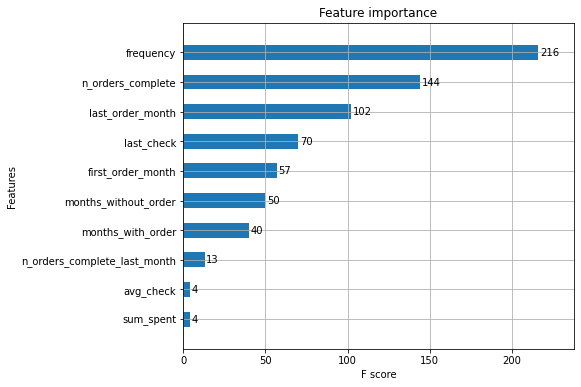

In [431]:
# F-score for XGboost, sums up how many times each feature is split on
fig, ax = plt.subplots(figsize=(7, 6))
plot_importance(xg, ax = ax, height=0.5,  max_num_features= 20)

In [432]:
threshold_XGB = 0.1

# F1-score



In [433]:
metrics.f1_score(test_y, (score_test_XGB > threshold_XGB))

0.811024214167544

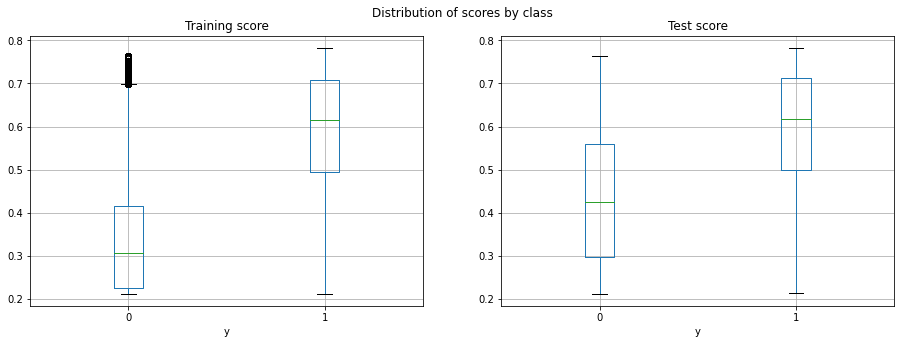

In [434]:
# Distribution of scores by class

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

(pd.DataFrame({'y': train_y, 'Training score': score_train_XGB})
 .boxplot(column='Training score', by='y',
          showfliers=True, ax=ax[0]))
plt.title('Training score')

(pd.DataFrame({'y': test_y, 'Test score': score_test_XGB})
 .boxplot(column='Test score', by='y', showfliers=True, ax=ax[1]))
plt.title('Test score')

plt.suptitle('Distribution of scores by class')

plt.show()

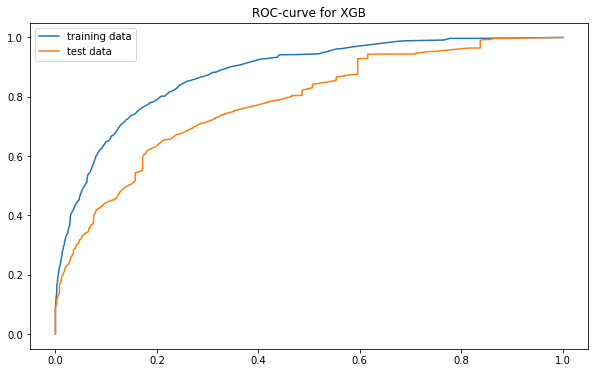

In [435]:
# ROC Curve
fpr_train_XGB, tpr_train_XGB, thresholds_train_XGB = metrics.roc_curve(train_y, score_train_XGB, pos_label=1)
fpr_test_XGB, tpr_test_XGB, thresholds_test_XGB = metrics.roc_curve(test_y, score_test_XGB, pos_label=1)

fig = plt.figure(figsize=(10, 6))
plt.plot(fpr_train_XGB, tpr_train_XGB, label='training data')
plt.plot(fpr_test_XGB, tpr_test_XGB, label='test data')
plt.legend()
plt.title('ROC-curve for XGB')
plt.show()

In [436]:
# AUC and accuracy
auc_train_XGB = metrics.roc_auc_score(train_y, score_train_XGB)
accuracy_train_XGB = metrics.accuracy_score(train_y, (score_train_XGB > threshold_XGB))

auc_test_XGB = metrics.roc_auc_score(test_y, score_test_XGB)
accuracy_test_XGB = metrics.accuracy_score(test_y, (score_test_XGB > threshold_XGB))

print('Training data:\nAUC: {auc}\tAccuracy: {acc}\n'
      .format(auc=auc_train_XGB, acc=accuracy_train_XGB))

print('Test data:\nAUC: {auc}\tAccuracy: {acc}'
      .format(auc=auc_test_XGB, acc=accuracy_test_XGB))

Training data:
AUC: 0.8788031734999271	Accuracy: 0.4257487643471388

Test data:
AUC: 0.7797346957619175	Accuracy: 0.6821200430080324


Calculating prediction for the sample

In [437]:
#sample = pd.read_csv(io.BytesIO(uploaded['sample_submission.csv']), sep=';')
#sample.head()

# Confusion matrix

In [438]:
metrics.confusion_matrix(test_y, (score_test_XGB > threshold_XGB))

array([[    0, 10052],
       [    0, 21570]])

# Prediction

In [439]:
ids_no_train_data =  submission_features[submission_features.isnull().any(axis=1)]['Id']
submission_features_in_train = submission_features[~submission_features.isnull().any(axis=1)]


In [440]:
ids_in_train_data = submission_features[submission_features['Id'].isin(train_v2['phone_id'])]

In [441]:
submission_features_in_train = submission_features[submission_features['Id'].isin(train_v2['phone_id'])]

In [442]:
submission_features_in_train

,Id,months_with_order,months_without_order,last_order_month,first_order_month,age,n_orders_complete,n_orders_canceled,avg_check,max_check,sum_spent,last_check,max_rate,was_rate_1,last_rate,n_orders_complete_last_month,max_duration,avg_duration,frequency,gender_Third,gender_female,gender_male
0,19843,2,5,7,0,31.000000,2,6,49.000000,98.0,98.0,98.0,5,0,5,1,66.766667,22.975000,0.250000,1,0,0
2,342522,1,6,6,0,31.000000,2,0,178.500000,199.0,357.0,199.0,0,0,0,1,124.783333,110.233333,0.285714,1,0,0
4,233778,2,1,7,0,31.000000,4,0,149.250000,199.0,597.0,0.0,0,0,0,2,69.166667,43.325000,0.500000,1,0,0
5,40738,4,2,6,0,31.000000,15,1,33.133333,199.0,497.0,0.0,5,0,5,3,361.166667,83.291111,2.142857,1,0,0
7,174054,4,0,7,4,31.000000,5,1,185.600000,267.0,928.0,267.0,0,0,0,1,111.466667,82.110000,1.250000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214603,238680,2,1,6,0,31.000000,5,0,102.400000,158.0,512.0,158.0,5,0,5,1,98.850000,40.710000,0.714286,1,0,0
214604,16841,3,0,7,5,31.000000,9,0,132.000000,269.0,1188.0,1.0,5,0,0,3,131.566667,86.368519,3.000000,1,0,0
214605,69348,2,1,6,0,31.000000,6,0,42.666667,158.0,256.0,158.0,5,0,5,2,103.183333,13.733333,0.857143,1,0,0
214607,320024,2,1,6,0,31.000000,4,0,104.500000,418.0,418.0,0.0,5,0,3,1,76.350000,40.425000,0.571429,1,0,0


In [443]:
submission_features_in_train.drop(['Id'], axis = 1)

,months_with_order,months_without_order,last_order_month,first_order_month,age,n_orders_complete,n_orders_canceled,avg_check,max_check,sum_spent,last_check,max_rate,was_rate_1,last_rate,n_orders_complete_last_month,max_duration,avg_duration,frequency,gender_Third,gender_female,gender_male
0,2,5,7,0,31.000000,2,6,49.000000,98.0,98.0,98.0,5,0,5,1,66.766667,22.975000,0.250000,1,0,0
2,1,6,6,0,31.000000,2,0,178.500000,199.0,357.0,199.0,0,0,0,1,124.783333,110.233333,0.285714,1,0,0
4,2,1,7,0,31.000000,4,0,149.250000,199.0,597.0,0.0,0,0,0,2,69.166667,43.325000,0.500000,1,0,0
5,4,2,6,0,31.000000,15,1,33.133333,199.0,497.0,0.0,5,0,5,3,361.166667,83.291111,2.142857,1,0,0
7,4,0,7,4,31.000000,5,1,185.600000,267.0,928.0,267.0,0,0,0,1,111.466667,82.110000,1.250000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214603,2,1,6,0,31.000000,5,0,102.400000,158.0,512.0,158.0,5,0,5,1,98.850000,40.710000,0.714286,1,0,0
214604,3,0,7,5,31.000000,9,0,132.000000,269.0,1188.0,1.0,5,0,0,3,131.566667,86.368519,3.000000,1,0,0
214605,2,1,6,0,31.000000,6,0,42.666667,158.0,256.0,158.0,5,0,5,2,103.183333,13.733333,0.857143,1,0,0
214607,2,1,6,0,31.000000,4,0,104.500000,418.0,418.0,0.0,5,0,3,1,76.350000,40.425000,0.571429,1,0,0


In [444]:
probabilities = xg.predict_proba(submission_features_in_train.drop(['Id'], axis = 1))
submission_features_in_train['Predicted'] = probabilities[:, 1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [445]:
submission_features = submission_features.merge(submission_features_in_train[['Id', 'Predicted']] , on='Id', how='left')[['Id', 'Predicted']]

In [446]:
submission_features = submission_features.fillna(1)
submission_features['Predicted'] = 1*(submission_features['Predicted'] > threshold_XGB)

In [447]:
submission_features_in_train['Predicted'] = submission_features['Predicted'] > threshold_XGB

In [448]:
submission_features.to_csv( './drive/My Drive/Colab Notebooks/NGWL The Glorious Chargers/02_submit/submit_21.csv' , index=False)